In [3]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import udf, col, when
import numpy as np
from IPython.display import Image
from IPython.display import display


In [1]:
directory="ml-latest-small"

In [4]:
spark = SparkSession.builder.appName('MrecommendDemo').getOrCreate()

In [5]:
sc=spark.sparkContext
sqlContext=SQLContext(sc)

In [6]:
ratings_df=spark.read.csv(directory+'/ratings.csv' , inferSchema=True , header=True)
ratings_df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



In [7]:
ratings_df.show(1)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
+------+-------+------+---------+
only showing top 1 row



In [8]:
movies_df=spark.read.csv(directory+'/movies.csv' , inferSchema=True , header=True)
movies_df.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



In [9]:
movies_df.show(1)

+-------+----------------+--------------------+
|movieId|           title|              genres|
+-------+----------------+--------------------+
|      1|Toy Story (1995)|Adventure|Animati...|
+-------+----------------+--------------------+
only showing top 1 row



In [10]:
links_df=spark.read.csv(directory+'/links.csv' , inferSchema=True , header=True)
links_df.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- imdbId: integer (nullable = true)
 |-- tmdbId: integer (nullable = true)



In [11]:
links_df.show(1)

+-------+------+------+
|movieId|imdbId|tmdbId|
+-------+------+------+
|      1|114709|   862|
+-------+------+------+
only showing top 1 row



In [12]:
training_df , validation_df=ratings_df.randomSplit([0.8 , 0.2])

In [13]:
iterations=10
regularization_parameter=0.1
ranks=4
errors=[]
err=0

In [14]:
als=ALS(maxIter=iterations , regParam=regularization_parameter, rank=4, userCol="userId" , itemCol="movieId" , ratingCol="rating")
model=als.fit(training_df)
predictions=model.transform(validation_df)
new_predictions=predictions.filter(col('prediction')!=np.nan)
evaluator= RegressionEvaluator(metricName="rmse", labelCol="rating" , predictionCol="prediction")
rmse=evaluator.evaluate(new_predictions)
print("Root-mean-square error= " +str(rmse))

Root-mean-square error= 0.8781610601833917


In [15]:
als=ALS(maxIter=iterations , regParam=regularization_parameter, rank=5, userCol="userId" , itemCol="movieId" , ratingCol="rating")
model=als.fit(training_df)
predictions=model.transform(validation_df)
new_predictions=predictions.filter(col('prediction')!=np.nan)
evaluator= RegressionEvaluator(metricName="rmse", labelCol="rating" , predictionCol="prediction")
rmse=evaluator.evaluate(new_predictions)
print("Root-mean-square error= " +str(rmse))

Root-mean-square error= 0.8836466002135155


In [16]:
predictions.show(n=10)

+------+-------+------+----------+----------+
|userId|movieId|rating| timestamp|prediction|
+------+-------+------+----------+----------+
|   603|    471|   4.0| 954482443| 2.7862368|
|   520|    471|   5.0|1326609921| 3.6320193|
|   448|    471|   4.0|1178980875| 3.7549217|
|   373|    471|   5.0| 846830388|  3.206162|
|   608|    833|   0.5|1117506344| 2.4650097|
|   599|   1088|   2.5|1498515232| 2.7393043|
|   111|   1088|   3.0|1516153967| 3.4151444|
|    41|   1088|   1.5|1458939142|  2.757522|
|   563|   1088|   4.0|1440793700| 3.4401412|
|   387|   1088|   1.5|1095040878| 2.9370475|
+------+-------+------+----------+----------+
only showing top 10 rows



In [17]:
predictions.join(movies_df, "movieId").select("userId" , "title" , "genres" , "prediction").show(10)

+------+--------------------+--------------------+----------+
|userId|               title|              genres|prediction|
+------+--------------------+--------------------+----------+
|   603|Hudsucker Proxy, ...|              Comedy| 2.7862368|
|   520|Hudsucker Proxy, ...|              Comedy| 3.6320193|
|   448|Hudsucker Proxy, ...|              Comedy| 3.7549217|
|   373|Hudsucker Proxy, ...|              Comedy|  3.206162|
|   608|High School High ...|              Comedy| 2.4650097|
|   599|Dirty Dancing (1987)|Drama|Musical|Rom...| 2.7393043|
|   111|Dirty Dancing (1987)|Drama|Musical|Rom...| 3.4151444|
|    41|Dirty Dancing (1987)|Drama|Musical|Rom...|  2.757522|
|   563|Dirty Dancing (1987)|Drama|Musical|Rom...| 3.4401412|
|   387|Dirty Dancing (1987)|Drama|Musical|Rom...| 2.9370475|
+------+--------------------+--------------------+----------+
only showing top 10 rows



In [18]:
for_one_user=predictions.filter(col("userId")==599).join(movies_df , "movieId").join(links_df , "movieId").select("userId" , "title" ,"genres", "tmdbId" , "prediction").show(10)

+------+--------------------+--------------------+------+----------+
|userId|               title|              genres|tmdbId|prediction|
+------+--------------------+--------------------+------+----------+
|   599|Dirty Dancing (1987)|Drama|Musical|Rom...|    88| 2.7393043|
|   599|Out of Africa (1985)|       Drama|Romance|   606| 2.9411056|
|   599|Before Sunset (2004)|       Drama|Romance|    80| 3.1969302|
|   599| Genius Party (2007)|           Animation| 40123|       NaN|
|   599|      Titanic (1997)|       Drama|Romance|   597| 2.6028688|
|   599|     Toy, The (1982)|              Comedy| 23805| 1.5655432|
|   599|Renaissance Man (...|        Comedy|Drama| 11858| 2.2557201|
|   599|Dracula (Bram Sto...|Fantasy|Horror|Ro...|  6114| 2.9218915|
|   599|Albino Alligator ...|      Crime|Thriller|  8744| 1.4491887|
|   599|Coming to America...|      Comedy|Romance|  9602| 2.6558876|
+------+--------------------+--------------------+------+----------+
only showing top 10 rows



In [19]:
import webbrowser
link="https://www.themoviedb.org/movie"


In [ ]:
for movie in predictions.take(2):
    movieURL=link+str(movie.title)
    print(movie.title)
    webbrowser.open(movieURL)

In [24]:
userRecommends = model.recommendForAllUsers(5)
movieRecommends = model.recommendForAllItems(5)

In [25]:
userRecommends.printSchema()

root
 |-- userId: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- movieId: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)



In [26]:
userRecommends.select("UserId" , "recommendations.movieId").show(10, False)

+------+-----------------------------------+
|UserId|movieId                            |
+------+-----------------------------------+
|471   |[6818, 8477, 96004, 132333, 5490]  |
|463   |[7842, 60943, 59018, 96004, 33649] |
|496   |[32582, 96004, 6818, 68945, 84847] |
|148   |[6818, 87234, 183897, 49347, 25771]|
|540   |[7842, 96004, 33649, 6818, 59018]  |
|392   |[86347, 84847, 70946, 6818, 86377] |
|243   |[156726, 86320, 45503, 2563, 3567] |
|31    |[5034, 2563, 77846, 25906, 93008]  |
|516   |[7842, 3200, 33649, 84273, 117531] |
|580   |[7842, 60943, 59018, 156726, 7841] |
+------+-----------------------------------+
only showing top 10 rows



In [27]:
users = ratings_df.select("userId").distinct().limit(3);
users.show()


+------+
|userId|
+------+
|   148|
|   463|
|   471|
+------+



In [28]:
userSubsetRecs=model.recommendForUserSubset(users, 10)
userSubsetRecs.show()

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|   471|[{6818, 5.5831156...|
|   463|[{7842, 5.522167}...|
|   148|[{6818, 5.2856975...|
+------+--------------------+



In [29]:
userSubsetRecs.select("userId" , "recommendations.movieId").show(10 , False)

+------+------------------------------------------------------------------------+
|userId|movieId                                                                 |
+------+------------------------------------------------------------------------+
|471   |[6818, 8477, 96004, 132333, 5490, 148881, 5915, 33649, 53, 25771]       |
|463   |[7842, 60943, 59018, 96004, 33649, 156726, 117531, 72171, 84273, 179135]|
|148   |[6818, 87234, 183897, 49347, 25771, 8477, 2524, 148881, 89904, 132333]  |
+------+------------------------------------------------------------------------+



In [30]:
movies=ratings_df.select("movieId").distinct().limit(3)
movies.show()

+-------+
|movieId|
+-------+
|   1580|
|   2366|
|   3175|
+-------+



In [31]:
movieSubSetRecs=model.recommendForItemSubset(movies, 10)
movieSubSetRecs.select("movieId" , "recommendations.userId").show(10 , False)

+-------+------------------------------------------------+
|movieId|userId                                          |
+-------+------------------------------------------------+
|1580   |[53, 276, 543, 243, 93, 452, 337, 523, 569, 327]|
|3175   |[53, 276, 543, 243, 93, 337, 558, 452, 569, 447]|
|2366   |[53, 494, 236, 296, 122, 90, 171, 447, 51, 597] |
+-------+------------------------------------------------+



In [32]:
movie_ids=[1580 , 3175 , 2366, 1590]
user_ids=[543, 543 , 543 , 543]

In [38]:
new_user_preds = sqlContext.createDataFrame(zip(movie_ids, user_ids), schema=['movieId' , 'userId'])

In [39]:
new_predictions = model.transform(new_user_preds)


In [41]:
new_predictions.show(3)

+------+-------+------+----------+----------+
|userId|movieId|rating| timestamp|prediction|
+------+-------+------+----------+----------+
|   603|    471|   4.0| 954482443| 2.7862368|
|   520|    471|   5.0|1326609921| 3.6320193|
|   448|    471|   4.0|1178980875| 3.7549217|
+------+-------+------+----------+----------+
only showing top 3 rows



In [42]:
# Default Packages (available by Default in Google Colab)
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import random
from pprint import pprint
from matplotlib.lines import Line2D
import databricks.koalas

In [43]:
dfRatingsKdf = ratings_df.to_koalas()

<timed exec>:7: UserWarning:

FixedFormatter should only be used together with FixedLocator

<timed exec>:8: UserWarning:

FixedFormatter should only be used together with FixedLocator



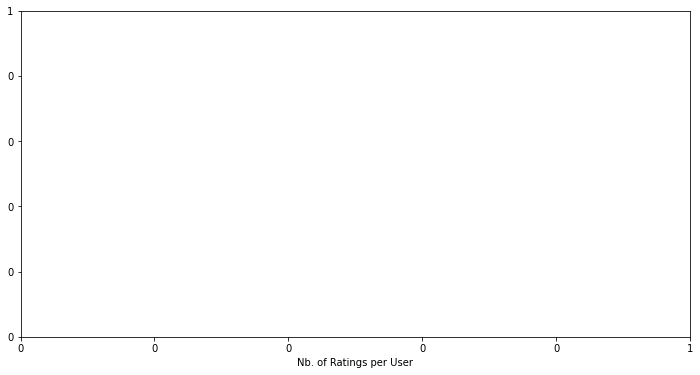

Wall time: 14.3 s


In [44]:
%%time
f, ax = plt.subplots(figsize=(12,6))
userRatingGroup = dfRatingsKdf.groupby("userId")['rating'].count()
userRatingGroup.hist(bins=100, color='blue', edgecolor='black',
                     linewidth=1.25, alpha=0.78, ax=ax)
ax.set_xlabel('Nb. of Ratings per User')
ax.set_xlim(0.0)
ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks().tolist()])
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
plt.show()

<timed exec>:19: UserWarning:

FixedFormatter should only be used together with FixedLocator



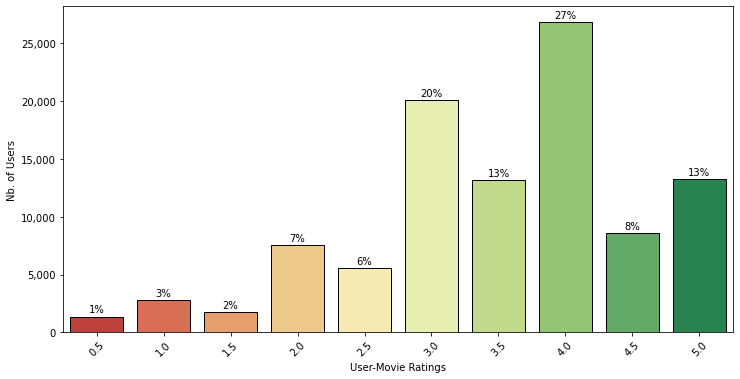

Wall time: 4.47 s


In [45]:
%%time
movieRatingDistGroup = dfRatingsKdf['rating'].value_counts() \
                                             .sort_index() \
                                             .reset_index() \
                                             .to_pandas()

# Create Matplotlib Figure
fig, ax = plt.subplots(figsize=(12,6))

# Main Figure: Seaborn Barplot
sns.barplot(data=movieRatingDistGroup, x='index', y='rating',
            palette='RdYlGn', edgecolor="black", ax=ax)

# Set Xaxis and Yaxis
ax.set_xlabel("User-Movie Ratings")
ax.set_ylabel('Nb. of Users')
ax.xaxis.set_tick_params(rotation=45)

# Thousand separator on Yaxis labels
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

# Add percentage text on top of each bar
total = float(movieRatingDistGroup['rating'].sum())
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+350,
            '{0:.0%}'.format(height/total),
            ha="center") 

# Display plot
plt.show()

In [46]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns
movies = pd.read_csv("ml-latest-small/movies.csv")
ratings = pd.read_csv("ml-latest-small/ratings.csv")

In [50]:
movies.head()


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [49]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [48]:
final_dataset = ratings.pivot(index='movieId',columns='userId',values='rating')
final_dataset.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
final_dataset.fillna(0,inplace=True)
final_dataset.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
no_user_voted = ratings.groupby('movieId')['rating'].agg('count')
no_movies_voted = ratings.groupby('userId')['rating'].agg('count')

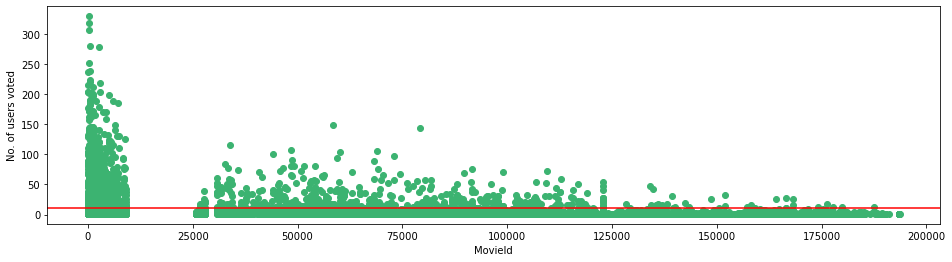

In [54]:
f,ax = plt.subplots(1,1,figsize=(16,4))
# ratings['rating'].plot(kind='hist')
plt.scatter(no_user_voted.index,no_user_voted,color='mediumseagreen')
plt.axhline(y=10,color='r')
plt.xlabel('MovieId')
plt.ylabel('No. of users voted')
plt.show()

In [57]:
final_dataset = final_dataset.loc[no_user_voted[no_user_voted > 10].index,:]


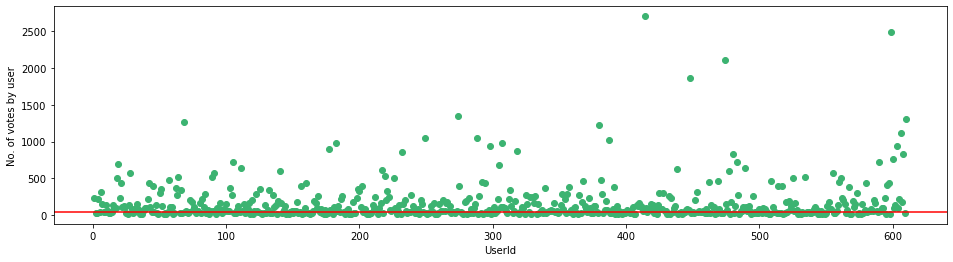

In [58]:
f,ax = plt.subplots(1,1,figsize=(16,4))
plt.scatter(no_movies_voted.index,no_movies_voted,color='mediumseagreen')
plt.axhline(y=50,color='r')
plt.xlabel('UserId')
plt.ylabel('No. of votes by user')
plt.show()

In [59]:
final_dataset=final_dataset.loc[:,no_movies_voted[no_movies_voted > 50].index]
final_dataset

userId,1,4,6,7,10,11,15,16,17,18,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,...,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
176371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
177765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
sample = np.array([[0,0,3,0,0],[4,0,0,0,2],[0,0,0,0,1]])
sparsity = 1.0 - ( np.count_nonzero(sample) / float(sample.size) )
print(sparsity)

0.7333333333333334


In [61]:
csr_sample = csr_matrix(sample)
print(csr_sample)

  (0, 2)	3
  (1, 0)	4
  (1, 4)	2
  (2, 4)	1


In [62]:
csr_data = csr_matrix(final_dataset.values)
final_dataset.reset_index(inplace=True)

In [63]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn.fit(csr_data)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [64]:
def get_movie_recommendation(movie_name):
    n_movies_to_reccomend = 10
    movie_list = movies[movies['title'].str.contains(movie_name)]  
    if len(movie_list):        
        movie_idx= movie_list.iloc[0]['movieId']
        movie_idx = final_dataset[final_dataset['movieId'] == movie_idx].index[0]
        distances , indices = knn.kneighbors(csr_data[movie_idx],n_neighbors=n_movies_to_reccomend+1)    
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),key=lambda x: x[1])[:0:-1]
        recommend_frame = []
        for val in rec_movie_indices:
            movie_idx = final_dataset.iloc[val[0]]['movieId']
            idx = movies[movies['movieId'] == movie_idx].index
            recommend_frame.append({'Title':movies.iloc[idx]['title'].values[0],'Distance':val[1]})
        df = pd.DataFrame(recommend_frame,index=range(1,n_movies_to_reccomend+1))
        return df
    else:
        return "No movies found. Please check your input"

In [65]:
get_movie_recommendation('Iron Man')

,Title,Distance
1,Up (2009),0.368857
2,Guardians of the Galaxy (2014),0.368758
3,Watchmen (2009),0.368558
4,Star Trek (2009),0.366029
5,Batman Begins (2005),0.362759
6,Avatar (2009),0.310893
7,Iron Man 2 (2010),0.307492
8,WALL·E (2008),0.298138
9,"Dark Knight, The (2008)",0.285835
10,"Avengers, The (2012)",0.285319


In [66]:
get_movie_recommendation('Jumanji')

,Title,Distance
1,Casper (1995),0.474253
2,Stargate (1994),0.469654
3,"Nightmare Before Christmas, The (1993)",0.462612
4,Home Alone (1990),0.443432
5,Beauty and the Beast (1991),0.435007
6,Aladdin (1992),0.425428
7,Jurassic Park (1993),0.420563
8,Mrs. Doubtfire (1993),0.416164
9,"Mask, The (1994)",0.413743
10,"Lion King, The (1994)",0.377013


In [67]:
#import modules
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler



In [78]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import fuzzywuzzy
from fuzzywuzzy import process
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_colwidth',1000)

In [79]:
moviepath = 'tmdb_5000_movies.csv'
creditspath = 'tmdb_5000_credits.csv'

In [80]:
movies = pd.read_csv(moviepath, error_bad_lines=False)

credits = pd.read_csv(creditspath, error_bad_lines=False)

In [81]:
movies.isna().sum()

budget                     0
genres                     0
homepage                3091
id                         0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title                      0
vote_average               0
vote_count                 0
dtype: int64

In [82]:
movies.head(5)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {""id"": 878, ""name"": ""Science Fiction""}]",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"": 2964, ""name"": ""future""}, {""id"": 3386, ""name"": ""space war""}, {""id"": 3388, ""name"": ""space colony""}, {""id"": 3679, ""name"": ""society""}, {""id"": 3801, ""name"": ""space travel""}, {""id"": 9685, ""name"": ""futuristic""}, {""id"": 9840, ""name"": ""romance""}, {""id"": 9882, ""name"": ""space""}, {""id"": 9951, ""name"": ""alien""}, {""id"": 10148, ""name"": ""tribe""}, {""id"": 10158, ""name"": ""alien planet""}, {""id"": 10987, ""name"": ""cgi""}, {""id"": 11399, ""name"": ""marine""}, {""id"": 13065, ""name"": ""soldier""}, {""id"": 14643, ""name"": ""battle""}, {""id"": 14720, ""name"": ""love affair""}, {""id"": 165431, ""name"": ""anti war""}, {""id"": 193554, ""name"": ""power relations""}, {""id"": 206690, ""name"": ""mind and soul""}, {""id"": 209714, ""name"": ""3d""}]",en,Avatar,"In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization.",150.44,"[{""name"": ""Ingenious Film Partners"", ""id"": 289}, {""name"": ""Twentieth Century Fox Film Corporation"", ""id"": 306}, {""name"": ""Dune Entertainment"", ""id"": 444}, {""name"": ""Lightstorm Entertainment"", ""id"": 574}]","[{""iso_3166_1"": ""US"", ""name"": ""United States of America""}, {""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""}]",2009-12-10,2787965087,162.00,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,Enter the World of Pandora.,Avatar,7.20,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {""id"": 28, ""name"": ""Action""}]",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""name"": ""drug abuse""}, {""id"": 911, ""name"": ""exotic island""}, {""id"": 1319, ""name"": ""east india trading company""}, {""id"": 2038, ""name"": ""love of one's life""}, {""id"": 2052, ""name"": ""traitor""}, {""id"": 2580, ""name"": ""shipwreck""}, {""id"": 2660, ""name"": ""strong woman""}, {""id"": 3799, ""name"": ""ship""}, {""id"": 5740, ""name"": ""alliance""}, {""id"": 5941, ""name"": ""calypso""}, {""id"": 6155, ""name"": ""afterlife""}, {""id"": 6211, ""name"": ""fighter""}, {""id"": 12988, ""name"": ""pirate""}, {""id"": 157186, ""name"": ""swashbuckler""}, {""id"": 179430, ""name"": ""aftercreditsstinger""}]",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, has come back to life and is headed to the edge of the Earth with Will Turner and Elizabeth Swann. But nothing is quite as it seems.",139.08,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""name"": ""Jerry Bruckheimer Films"", ""id"": 130}, {""name"": ""Second Mate Productions"", ""id"": 19936}]","[{""iso_3166_1"": ""US"", ""name"": ""United States of America""}]",2007-05-19,961000000,169.00,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.90,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 80, ""name"": ""Crime""}]",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name"": ""based on novel""}, {""id"": 4289, ""name"": ""secret agent""}, {""id"": 9663, ""name"": ""sequel""}, {""id"": 14555, ""name"": ""mi6""}, {""id"": 156095, ""name"": ""british secret service""}, {""id"": 158431, ""name"

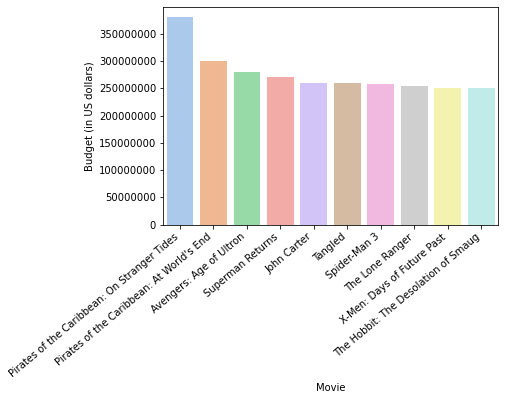

In [83]:
most_expensive_df = movies.sort_values('budget',ascending=False)[:10]

most_expensive = most_expensive_df[['title', 'budget', 'revenue']]

expensiveplot = sns.barplot(x = 'title',y='budget', data=most_expensive, palette="pastel")
expensiveplot.set_xticklabels(expensiveplot.get_xticklabels(), rotation=40, ha="right")
expensiveplot.set(xlabel='Movie', ylabel='Budget (in US dollars)')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [84]:
most_expensive

,title,budget,revenue
17,Pirates of the Caribbean: On Stranger Tides,380000000,1045713802
1,Pirates of the Caribbean: At World's End,300000000,961000000
7,Avengers: Age of Ultron,280000000,1405403694
10,Superman Returns,270000000,391081192
4,John Carter,260000000,284139100
6,Tangled,260000000,591794936
5,Spider-Man 3,258000000,890871626
13,The Lone Ranger,255000000,89289910
46,X-Men: Days of Future Past,250000000,747862775
22,The Hobbit: The Desolation of Smaug,250000000,958400000


In [85]:
most_popular_df = movies.sort_values('popularity',ascending=False)[:10]
most_popular = most_popular_df[['title', 'popularity', 'release_date']]
most_popular

,title,popularity,release_date
546,Minions,875.58,2015-06-17
95,Interstellar,724.25,2014-11-05
788,Deadpool,514.57,2016-02-09
94,Guardians of the Galaxy,481.10,2014-07-30
127,Mad Max: Fury Road,434.28,2015-05-13
28,Jurassic World,418.71,2015-06-09
199,Pirates of the Caribbean: The Curse of the Black Pearl,271.97,2003-07-09
82,Dawn of the Planet of the Apes,243.79,2014-06-26
200,The Hunger Games: Mockingjay - Part 1,206.23,2014-11-18
88,Big Hero 6,203.73,2014-10-24
